In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
%matplotlib inline
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests

# Used to measure whether our data is stationary
from statsmodels.tsa.stattools import adfuller

In [2]:
ice_cream_heater_df = pd.read_csv('https://raw.githubusercontent.com/ritvikmath/Time-Series-Analysis/master/ice_cream_vs_heater.csv')

In [3]:
ice_cream_heater_df['Month'] = pd.to_datetime(ice_cream_heater_df['Month'])
ice_cream_heater_df.index = ice_cream_heater_df['Month']
del ice_cream_heater_df['Month']

In [4]:
ice_cream_heater_df

,heater,ice cream
Month,,
2004-01-01,27,13
2004-02-01,18,15
2004-03-01,14,16
2004-04-01,13,19
2004-05-01,13,21
...,...,...
2020-02-01,34,45
2020-03-01,25,44
2020-04-01,25,53


In [5]:
fig = px.line(ice_cream_heater_df, x=ice_cream_heater_df.index , y=["heater","ice cream"], 
              title= "Ice Cream and Heater Sales Over Time",
              color_discrete_sequence=['red', 'blue'],
              labels={'Month': 'Time (in years)', 'value':'Sales (No. Units)'})
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

# Step 1: Normalize Data (Scaling)

In [6]:
def normalize_dataframe(df):
    avgs = df.mean()
    devs = df.std()
    for col in df.columns:
        df[col] = (df[col] - avgs.loc[col]) / devs.loc[col]
    return df, avgs, devs

def reverse_normalization(df, avgs, devs):
    for col in df.columns:
        df[col] = (df[col] * devs.loc[col]) + avgs.loc[col]
    return df

In [7]:
# Normalize the DataFrame
ice_cream_heater_df_normalized, avgs, devs = normalize_dataframe(ice_cream_heater_df)

# Display the normalized DataFrame
print("Normalized DataFrame:")
print(ice_cream_heater_df_normalized)

# Reverse the normalization and get the original DataFrame
#ice_cream_heater_df_reversed = reverse_normalization(ice_cream_heater_df_normalized, avgs, devs)

# Display the original DataFrame after reverse normalization
#print("\nOriginal DataFrame after reverse normalization:")
#print(ice_cream_heater_df_reversed)

Normalized DataFrame:
              heater  ice cream
Month                          
2004-01-01  0.429490  -1.174946
2004-02-01 -0.489299  -1.057807
2004-03-01 -0.897650  -0.999237
2004-04-01 -0.999738  -0.823527
2004-05-01 -0.999738  -0.706388
...              ...        ...
2020-02-01  1.144104   0.699288
2020-03-01  0.225315   0.640719
2020-04-01  0.225315   1.167847
2020-05-01  0.429490   2.163534
2020-06-01  0.123227   2.397814

[198 rows x 2 columns]


In [8]:
ice_cream_heater_df_normalized

,heater,ice cream
Month,,
2004-01-01,0.429490,-1.174946
2004-02-01,-0.489299,-1.057807
2004-03-01,-0.897650,-0.999237
2004-04-01,-0.999738,-0.823527
2004-05-01,-0.999738,-0.706388
...,...,...
2020-02-01,1.144104,0.699288
2020-03-01,0.225315,0.640719
2020-04-01,0.225315,1.167847


In [9]:
fig = px.line(ice_cream_heater_df_normalized, x=ice_cream_heater_df_normalized.index , y=["heater","ice cream"], 
              title= "Ice Cream and Heater Sales Over Time -- Normalized",
              color_discrete_sequence=['red', 'blue'],
              labels={'Month': 'Time (in years)', 'value':'Sales (No. Units)'})
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

# Step 2: Make Time Series Stationary

## Remove Non-Stationarity in Variance

In [10]:
import statsmodels.api as sm
from scipy.stats import boxcox

def adf_test(series):
    result = sm.tsa.stattools.adfuller(series)
    return result[0]

# define a function to calculate the log transformation
def log_transform(series):
    return np.sign(series) * np.log(np.abs(series))

# define a function to calculate the square root transformation
def sqrt_transform(series):
    return np.sign(series) * np.sqrt(np.abs(series))

In [11]:
transformations = [log_transform, sqrt_transform]

# calculate the ADF test statistic for each transformation
adf_results = {}
for transform in transformations:
    transformed_data = transform(ice_cream_heater_df_normalized['heater'])
    adf_results[str(transform.__name__)] = adf_test(transformed_data)

transformation_results = pd.DataFrame.from_dict(adf_results, orient='index', columns=['ADF Statistic'])
transformation_results # pick transformation with LOWEST ADF Statistic
# Log Transformation is the Best

,ADF Statistic
log_transform,-12.399376
sqrt_transform,1.293833


In [12]:
transformations = [log_transform, sqrt_transform]

# calculate the ADF test statistic for each transformation
adf_results = {}
for transform in transformations:
    transformed_data = transform(ice_cream_heater_df_normalized['ice cream'])
    adf_results[str(transform.__name__)] = adf_test(transformed_data)

transformation_results = pd.DataFrame.from_dict(adf_results, orient='index', columns=['ADF Statistic'])
transformation_results # pick transformation with LOWEST ADF Statistic
# Log Transformation is the Best

,ADF Statistic
log_transform,-2.394055
sqrt_transform,-0.490431


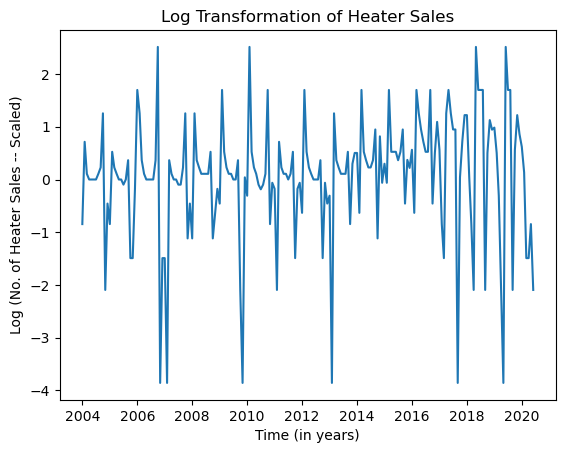

In [13]:
plt.plot(log_transform(ice_cream_heater_df_normalized['heater']))
plt.title("Log Transformation of Heater Sales")
plt.xlabel("Time (in years)")
plt.ylabel("Log (No. of Heater Sales -- Scaled)")
plt.show()

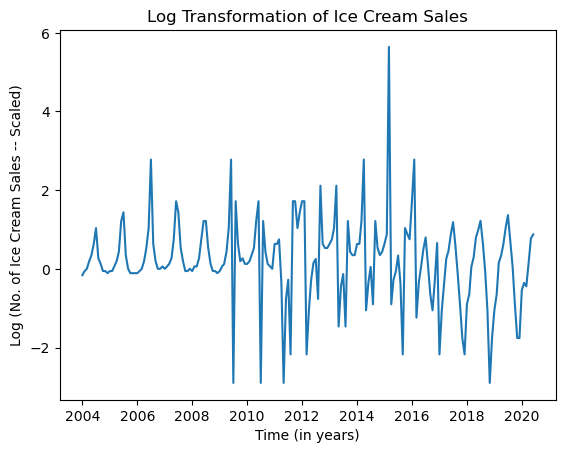

In [14]:
plt.plot(log_transform(ice_cream_heater_df_normalized['ice cream']))
plt.title("Log Transformation of Ice Cream Sales")
plt.xlabel("Time (in years)")
plt.ylabel("Log (No. of Ice Cream Sales -- Scaled)")
plt.show()

In [15]:
ice_cream_heater_df_normalized_log = log_transform(ice_cream_heater_df_normalized)

In [16]:
fig = px.line(ice_cream_heater_df_normalized_log, x=ice_cream_heater_df_normalized_log.index , y=["heater","ice cream"], 
              title= "Ice Cream and Heater Sales Over Time -- Normalized & Log Transform",
              color_discrete_sequence=['red', 'blue'],
              labels={'Month': 'Time (in years)', 'value':'Sales (No. Units)'})
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Remove Non-Stationarity in Mean

/Users/anishdulla/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



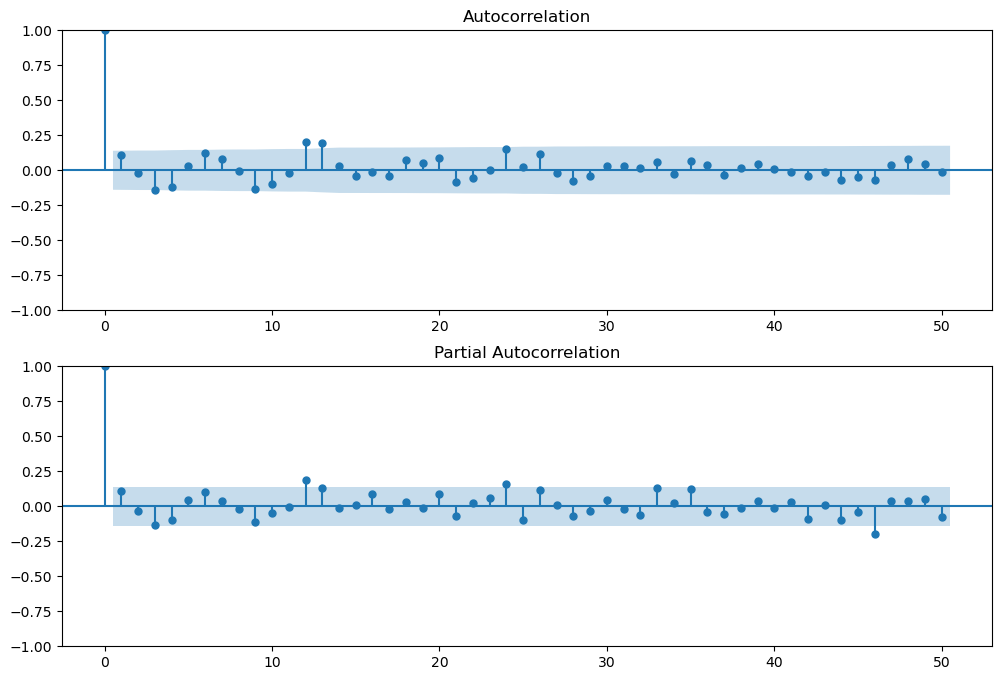

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ice_cream_heater_df_normalized_log['heater'], ax=ax1, lags=50)
plot_pacf(ice_cream_heater_df_normalized_log['heater'], ax=ax2, lags=50)
plt.show()

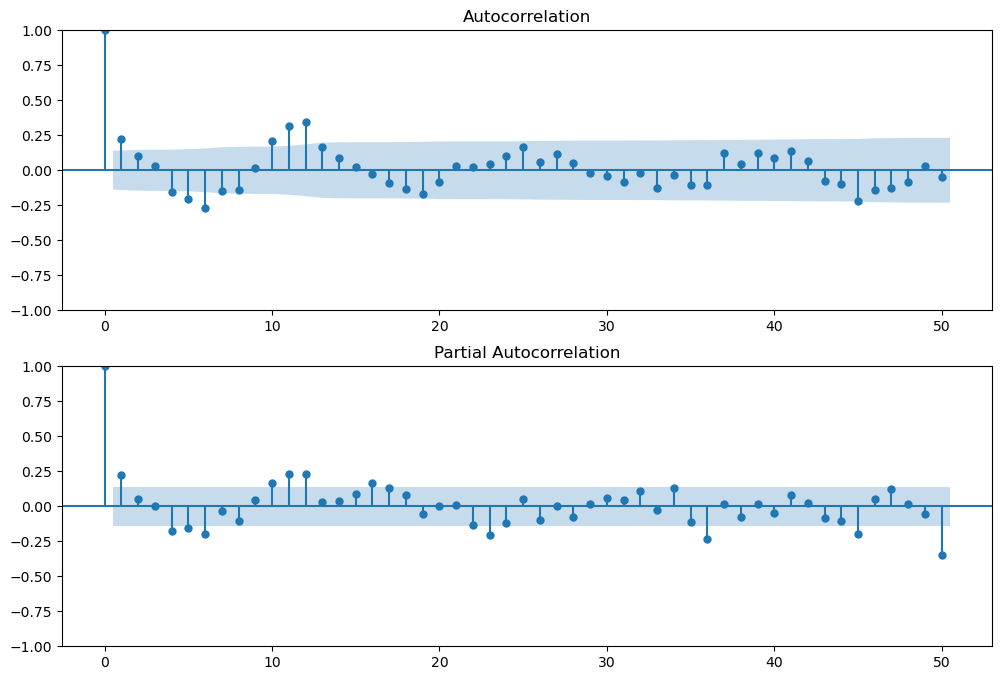

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ice_cream_heater_df_normalized_log['ice cream'], ax=ax1, lags=50)
plot_pacf(ice_cream_heater_df_normalized_log['ice cream'], ax=ax2, lags=50)
plt.show()

In [19]:
import statsmodels.api as sm
ADF_results = sm.tsa.stattools.adfuller(ice_cream_heater_df_normalized_log['heater'])

# Print the test statistics and p-values
print('ADF Statistic: %f' % ADF_results[0])
print('p-value: %f' % ADF_results[1])

ADF Statistic: -12.399376
p-value: 0.000000


In [20]:
import statsmodels.api as sm
ADF_results = sm.tsa.stattools.adfuller(ice_cream_heater_df_normalized_log['ice cream'])

# Print the test statistics and p-values
print('ADF Statistic: %f' % ADF_results[0])
print('p-value: %f' % ADF_results[1])

ADF Statistic: -2.394055
p-value: 0.143421


Although our heater variable is now stationary, our ice cream variable is not. <br> We must remove non-stationary in mean for the ice cream variable.

/Users/anishdulla/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



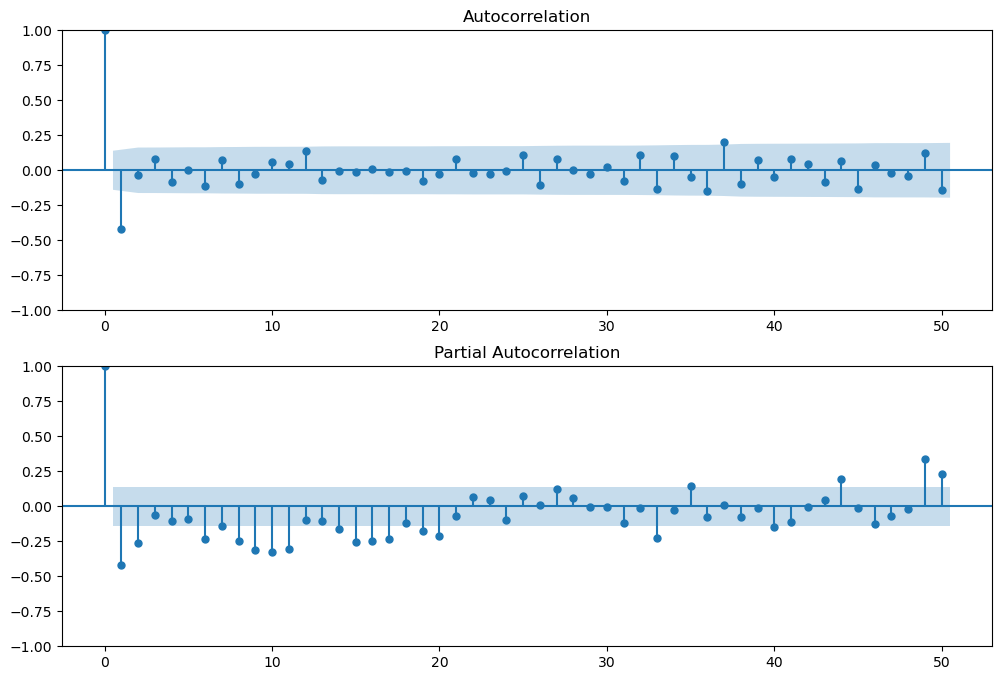

In [21]:
# 1st Order Regular Differencing
ice_cream_heater_df_normalized_log_diff1 = ice_cream_heater_df_normalized_log.diff().dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ice_cream_heater_df_normalized_log_diff1['ice cream'], ax=ax1, lags=50)
plot_pacf(ice_cream_heater_df_normalized_log_diff1['ice cream'], ax=ax2, lags=50)
plt.show()

In [22]:
import statsmodels.api as sm
ADF_results = sm.tsa.stattools.adfuller(ice_cream_heater_df_normalized_log_diff1['ice cream'])

# Print the test statistics and p-values
print('ADF Statistic: %f' % ADF_results[0])
print('p-value: %f' % ADF_results[1])

ADF Statistic: -7.586678
p-value: 0.000000


Because our p-value < 0.05, we reject the null hypothesis. We conclude our data is stationary.

In [23]:
fig = px.line(x=ice_cream_heater_df_normalized_log_diff1.index, y=ice_cream_heater_df_normalized_log_diff1['ice cream'], title="Amount of Ice Cream Sales Over Time - Normalized, Log Transformation & Regular Differencing", 
              labels={'x': 'Time (in years)', 'y':'No. Ice Cream Sales'})
fig.update_xaxes(rangeslider_visible=True)

fig

In [24]:
ice_cream_heater_df_normalized_log_diff1 = ice_cream_heater_df_normalized_log.copy()
ice_cream_heater_df_normalized_log_diff1['ice cream'] = ice_cream_heater_df_normalized_log_diff1['ice cream'].diff()
ice_cream_heater_df_normalized_log_diff1 = ice_cream_heater_df_normalized_log_diff1.dropna()

In [25]:
ice_cream_heater_df_normalized_log_diff1

,heater,ice cream
Month,,
2004-02-01,0.714781,0.105025
2004-03-01,0.107975,0.056961
2004-04-01,0.000263,0.193395
2004-05-01,0.000263,0.153433
2004-06-01,0.000263,0.286008
...,...,...
2020-02-01,0.134622,0.183337
2020-03-01,-1.490257,-0.087473
2020-04-01,-1.490257,0.600327


In [26]:
ADF_results = sm.tsa.stattools.adfuller(ice_cream_heater_df_normalized_log_diff1['ice cream'])

# Print the test statistics and p-values
print('ADF Statistic: %f' % ADF_results[0])
print('p-value: %f' % ADF_results[1])

ADF Statistic: -7.586678
p-value: 0.000000


In [27]:
fig = px.line(ice_cream_heater_df_normalized_log_diff1, x=ice_cream_heater_df_normalized_log_diff1.index , y=["heater","ice cream"], 
              title= "Ice Cream and Heater Sales Over Time -- Normalized, Log Transform, & Differenced",
              color_discrete_sequence=['red', 'blue'],
              labels={'Month': 'Time (in years)', 'value':'Sales (No. Units)'})
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

# Step 3: Split Time Series into Train and Test

First 80% of data kept for training. Last 20% of data left for testing. <br> Apply pre-processing and transformations only on training data. <br> Seperate test set ensures unbiased estimates from model.

In [28]:
ice_cream_heater_df_normalized_log_diff1.index.freq = 'MS'

In [29]:
ice_cream_heater_train = ice_cream_heater_df_normalized_log_diff1[:157]
ice_cream_heater_test = ice_cream_heater_df_normalized_log_diff1[157:]

# Step 4: Model Fitting

In [30]:
VAR_model = VAR(ice_cream_heater_train)

In [31]:
sorted_order = VAR_model.select_order(maxlags = 20)

sorted_order.summary()

,AIC,BIC,FPE,HQIC
0,0.9905,1.033,2.692,1.008
1,0.7765,0.9043*,2.174,0.8284
2,0.6966*,0.9097,2.007*,0.7832*
3,0.7159,1.014,2.046,0.8371
4,0.7430,1.127,2.103,0.8989
5,0.7683,1.237,2.158,0.9589
6,0.7538,1.308,2.128,0.9790
7,0.7913,1.431,2.210,1.051
8,0.8033,1.528,2.239,1.098
9,0.7896,1.600,2.211,1.119


In [32]:
VAR_model_fit = VAR_model.fit(maxlags = 2)
VAR_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 21, Aug, 2023
Time:                     01:26:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.702149
Nobs:                     155.000    HQIC:                  0.585551
Log likelihood:          -469.070    FPE:                    1.65838
AIC:                     0.505799    Det(Omega_mle):         1.55635
--------------------------------------------------------------------
Results for equation heater
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.032339         0.081344            0.398           0.691
L1.heater            0.071845         0.081753            0.879           0.380
L1.ice cream        -0.030099         0.062717           -0.480

# Step 5: Model Evaluation

In [33]:
# 2 represents VAR(p) order

idx = pd.date_range('2017-03-01', periods=40, freq='MS')
pred = VAR_model_fit.forecast(ice_cream_heater_train.values[-2:], len(ice_cream_heater_test))
df_model_predict = pd.DataFrame(data=pred, index=idx, columns=['heater', 'ice cream'])

In [34]:
df_model_predict.head()

,heater,ice cream
2017-03-01,-0.078174,0.312340
2017-04-01,-0.018615,-0.523503
2017-05-01,0.047444,0.225181
2017-06-01,0.017652,0.029916
2017-07-01,0.040255,-0.108121


https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/

# Plot CCF!